In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

warnings.filterwarnings('ignore')


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


基本変数定義

In [2]:
sampling_flg=0 #サンプリング有無をコントロール
submit_flg=1 #保存するかをコントロール（サンプリングしない時のみ）

SEED=12345
sample_num=10000
fold_num=5

#train関連
train_dir='../../01_input/train.csv'
train_feature_dir_1='../../02_feature/113_train_NegativeCount.csv'
train_feature_dir_2='../../02_feature/114_train_kmeans.csv'
train_feature_dir_3='../../02_feature/116_train_quantile.csv'
train_feature_dir_4='../../02_feature/102_train_kmeans.csv'

train_drop_col=['ID_code', 'target']
train_label='target'

#test関連
test_dir='../../01_input/test.csv'
test_feature_dir_1='../../02_feature/113_test_NegativeCount.csv'
test_feature_dir_2='../../02_feature/114_test_kmeans.csv'
test_feature_dir_3='../../02_feature/116_test_quantile.csv'
test_feature_dir_4='../../02_feature/102_test_kmeans.csv'

test_drop_col=['ID_code']

#結果ファイル関連　nameは自分の名前に変更する
train_preds_dir='../../03_predict_train/oka_224_LightGBM_Mean_NegCount_kmean_qcut_train.csv'
test_preds_dir='../../04_predict_test/oka_224_LightGBM_Mean_NegCount_kmean_qcut_submission.csv'
save_col_name='oof_xgb'

sample_submission_dir='../../01_input/sample_submission.csv'
submission_target_col_name='target'
submission_id_col_name='ID_code'

前処理

In [3]:
#ロード
train_df=pd.read_csv(train_dir)
test_df=pd.read_csv(test_dir)
train_feature_df_1=pd.read_csv(train_feature_dir_1)
test_feature_df_1=pd.read_csv(test_feature_dir_1)
train_feature_df_2=pd.read_csv(train_feature_dir_2)
test_feature_df_2=pd.read_csv(test_feature_dir_2)
#train_feature_df_3=pd.read_csv(train_feature_dir_3)
#test_feature_df_3=pd.read_csv(test_feature_dir_3)
#train_feature_df_4=pd.read_csv(train_feature_dir_4)
#test_feature_df_4=pd.read_csv(test_feature_dir_4)

train_df=pd.concat([train_df,train_feature_df_1],axis=1)
test_df=pd.concat([test_df,test_feature_df_1],axis=1)
train_df=pd.concat([train_df,train_feature_df_2],axis=1)
test_df=pd.concat([test_df,test_feature_df_2],axis=1)
#train_df=pd.concat([train_df,train_feature_df_3],axis=1)
#test_df=pd.concat([test_df,test_feature_df_3],axis=1)
#train_df=pd.concat([train_df,train_feature_df_4],axis=1)
#test_df=pd.concat([test_df,test_feature_df_4],axis=1)

In [4]:
pd.set_option('display.max_columns', 500)
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,NegCount,mean_0,negCount_0,mean_1,negCount_1,mean_2,negCount_2,mean_3,negCount_3,mean_4,negCount_4,mean_5,negCount_5,mean_6,negCount_6,mean_7,negCount_7,mean_8,negCount_8,mean_9,negCount_9,mean_10,negCount_10,mean_11,negCount_11,mean_12,negCount_12,mean_13,negCount_13,mean_14,negCount_14,mean_15,negCount_15,mean_16,negCount_16,mean_17,negCount_17,mean_18,negCount_18,mean_19,negCount_19,mean_20,negCount_20,mean_21,negCount_21,mean_22,negCount_22,mean_23,negCount_23,mean_24,negCount_24,mean_25,negCount_25,mean_26,negCount_26,mean_27,negCount_27,mean_28,negCount_28,mean_29,negCount_29,mean_30,negCount_30,mean_31,negCount_31,mean_32,negCount_32,mean_33,negCount_33,mean_34,negCount_34,mean_35,negCount_35,mean_36,negCount_36,mean_37,negCount_37,mean_38,negCount_38,mean_39,negCount_39,mean_40,negCount_40,mean_41,negCount_41,mean_42,negCount_42,mean_43,negCount_43,mean_44,negCount_44,mean_45,negCount_45,mean_46,negCount_46,mean_47,negCount_47,mean_48,negCount_48,mean_49,negCount_49,mean_50,negCount_50,mean_51,negCount_51,mean_52,negCount_52
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.57

In [5]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,NegCount,mean_0,negCount_0,mean_1,negCount_1,mean_2,negCount_2,mean_3,negCount_3,mean_4,negCount_4,mean_5,negCount_5,mean_6,negCount_6,mean_7,negCount_7,mean_8,negCount_8,mean_9,negCount_9,mean_10,negCount_10,mean_11,negCount_11,mean_12,negCount_12,mean_13,negCount_13,mean_14,negCount_14,mean_15,negCount_15,mean_16,negCount_16,mean_17,negCount_17,mean_18,negCount_18,mean_19,negCount_19,mean_20,negCount_20,mean_21,negCount_21,mean_22,negCount_22,mean_23,negCount_23,mean_24,negCount_24,mean_25,negCount_25,mean_26,negCount_26,mean_27,negCount_27,mean_28,negCount_28,mean_29,negCount_29,mean_30,negCount_30,mean_31,negCount_31,mean_32,negCount_32,mean_33,negCount_33,mean_34,negCount_34,mean_35,negCount_35,mean_36,negCount_36,mean_37,negCount_37,mean_38,negCount_38,mean_39,negCount_39,mean_40,negCount_40,mean_41,negCount_41,mean_42,negCount_42,mean_43,negCount_43,mean_44,negCount_44,mean_45,negCount_45,mean_46,negCount_46,mean_47,negCount_47,mean_48,negCount_48,mean_49,negCount_49,mean_50,negCount_50,mean_51,negCount_51,mean_52,negCount_52
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.

In [8]:
#サンプリング
if sampling_flg ==1:
    train_df=train_df.sample(n=sample_num,random_state=SEED)
    test_df=test_df.sample(n=sample_num,random_state=SEED)

In [9]:
#x,y作成
x_train=train_df.drop(train_drop_col,axis=1)
y_train=train_df[train_label]
x_test=test_df.drop(test_drop_col,axis=1)

モデル実行

In [10]:
#model_param
param = {
        'num_leaves': 2,
        'max_bin': 63,
        'min_data_in_leaf': 45,
        'learning_rate': 0.01,
        'min_sum_hessian_in_leaf': 0.000446,
        'bagging_fraction': 0.55, 
        'bagging_freq': 5, 
        'max_depth': 14,
        'save_binary': True,
        'seed': 31452,
        'feature_fraction_seed': 31415,
        'feature_fraction': 0.51,
        'bagging_seed': 31415,
        'drop_seed': 31415,
        'data_random_seed': 31415,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [11]:
folds = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
oof_preds = np.zeros((len(x_train), 1))
test_preds = np.zeros((len(x_test), 1))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("\n")
    print("Fold {}".format(fold_))
    trn_x,trn_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_x,val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    trn_data = lgb.Dataset(trn_x,trn_y)
    val_data = lgb.Dataset(val_x,val_y)
    
    num_round = 80000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 5000)
    val_pred = clf.predict(val_x, num_iteration=clf.best_iteration)
    test_pred = clf.predict(x_test, num_iteration=clf.best_iteration)
    
    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    #print("val = {}".format(val_pred)
    oof_preds[val_idx, :] = val_pred.reshape((-1, 1))
    test_preds += test_pred.reshape((-1, 1))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = x_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
test_preds /= fold_num
roc_score = roc_auc_score(y_train, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))



Fold 0
Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.793275	valid_1's auc: 0.789668
[2000]	training's auc: 0.830908	valid_1's auc: 0.827773
[3000]	training's auc: 0.850635	valid_1's auc: 0.846749
[4000]	training's auc: 0.862421	valid_1's auc: 0.857538
[5000]	training's auc: 0.87094	valid_1's auc: 0.865468
[6000]	training's auc: 0.877322	valid_1's auc: 0.871141
[7000]	training's auc: 0.882289	valid_1's auc: 0.875426
[8000]	training's auc: 0.885843	valid_1's auc: 0.878279
[9000]	training's auc: 0.889273	valid_1's auc: 0.881156
[10000]	training's auc: 0.892042	valid_1's auc: 0.883505
[11000]	training's auc: 0.894129	valid_1's auc: 0.885258
[12000]	training's auc: 0.896029	valid_1's auc: 0.886755
[13000]	training's auc: 0.897637	valid_1's auc: 0.888063
[14000]	training's auc: 0.898984	valid_1's auc: 0.889039
[15000]	training's auc: 0.900214	valid_1's auc: 0.890031
[16000]	training's auc: 0.901378	valid_1's auc: 0.890948
[17000]	training's auc: 0

[39000]	training's auc: 0.912402	valid_1's auc: 0.895673
[40000]	training's auc: 0.912665	valid_1's auc: 0.895745
[41000]	training's auc: 0.912899	valid_1's auc: 0.89582
[42000]	training's auc: 0.913147	valid_1's auc: 0.895831
[43000]	training's auc: 0.913383	valid_1's auc: 0.89583
[44000]	training's auc: 0.91361	valid_1's auc: 0.895874
[45000]	training's auc: 0.913831	valid_1's auc: 0.895866
[46000]	training's auc: 0.914055	valid_1's auc: 0.895847
[47000]	training's auc: 0.914275	valid_1's auc: 0.895852
[48000]	training's auc: 0.914482	valid_1's auc: 0.895892
[49000]	training's auc: 0.9147	valid_1's auc: 0.895898
[50000]	training's auc: 0.914904	valid_1's auc: 0.895859
[51000]	training's auc: 0.915098	valid_1's auc: 0.895826
[52000]	training's auc: 0.915288	valid_1's auc: 0.895901
[53000]	training's auc: 0.915488	valid_1's auc: 0.895899
Early stopping, best iteration is:
[48235]	training's auc: 0.914533	valid_1's auc: 0.895939
AUC = 0.8959392517678422


Fold 3
Training until validatio

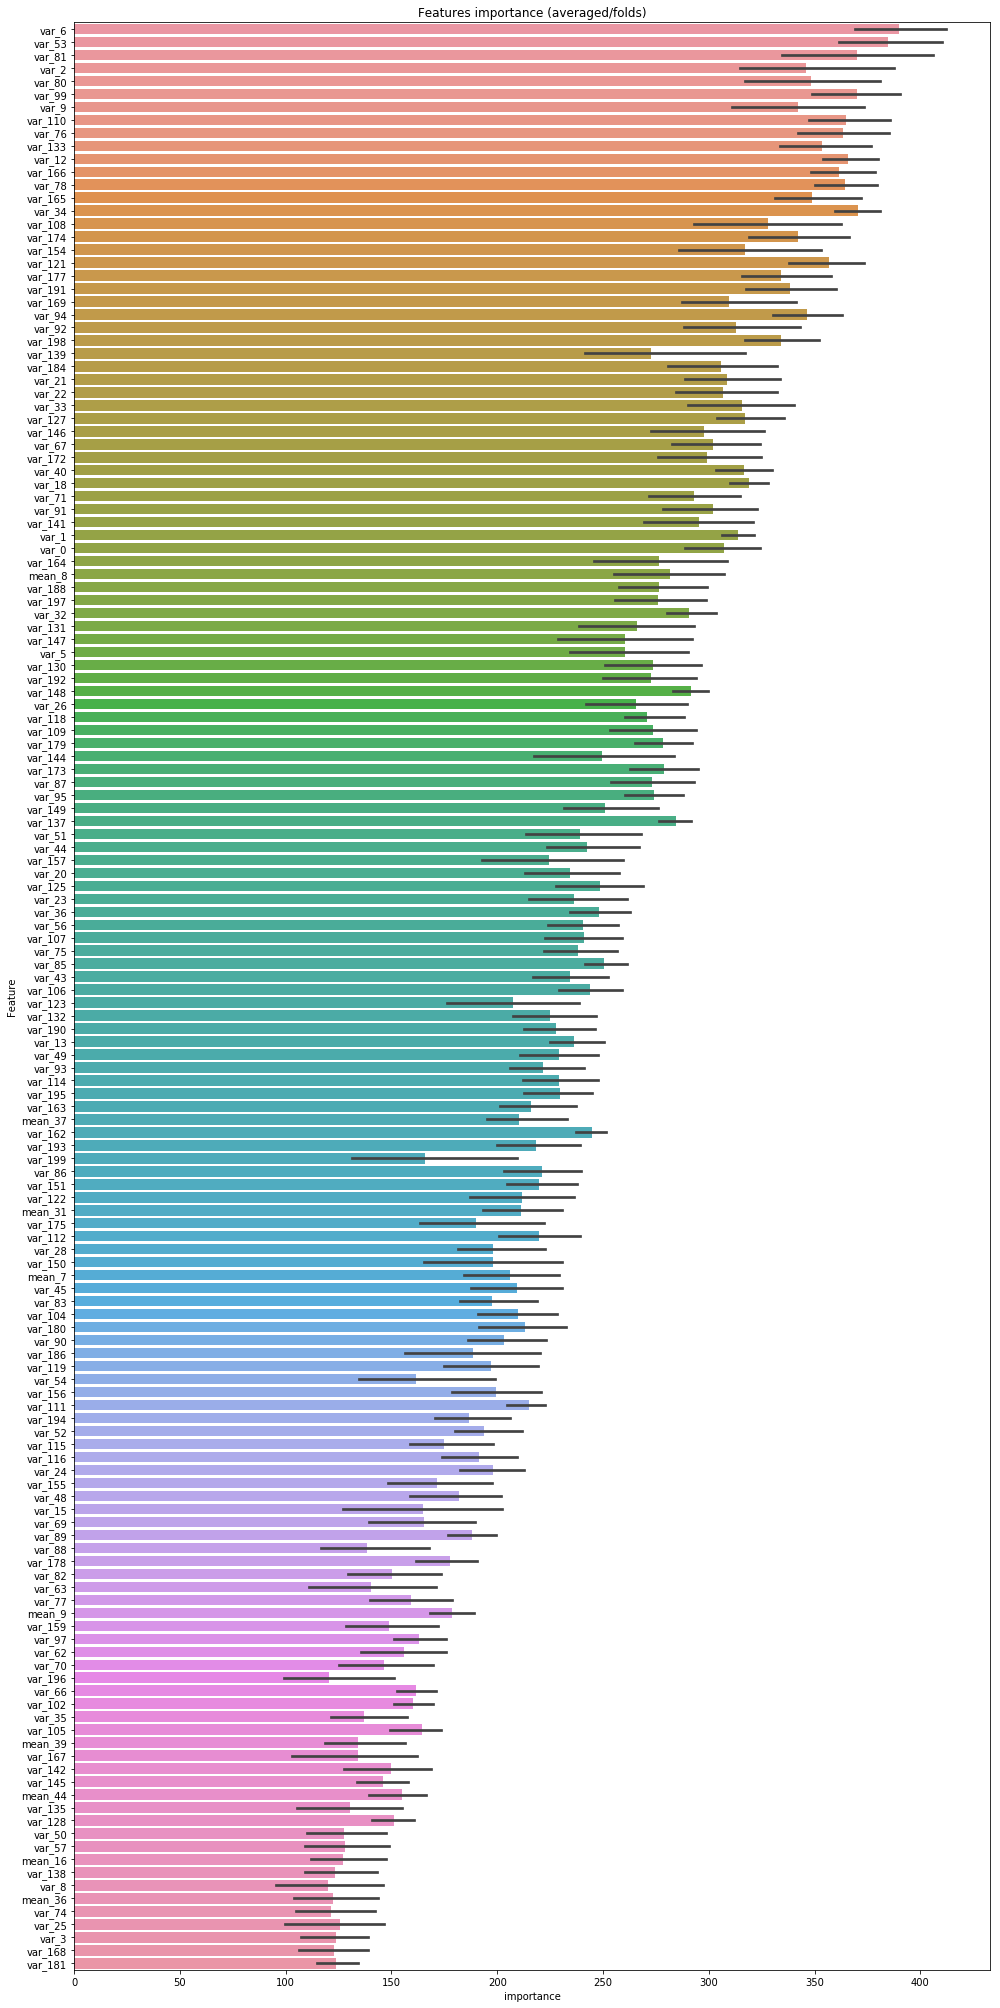

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('../../04_predict_test/221_FI.png')

In [13]:
#結果保存
if (submit_flg ==1 and sampling_flg==0):
    series_oof_preds = pd.Series(data=oof_preds[:,0], name=save_col_name, dtype='float')
    series_oof_preds.to_csv(train_preds_dir,header=True, index=False)

    sample = pd.read_csv(sample_submission_dir)
    sample.target = test_preds[:,0].astype(float)
    sample.ID_code = test_df['ID_code']
    sample.to_csv(test_preds_dir, index=False)
    